<a href="https://colab.research.google.com/github/albope/master-data-analytics-content/blob/master/EDEM_XGboost_(Practica_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries Prediction Practice 1
Using XGboost for prediction of time series

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

TensorFlow 2.x selected.


## Import data

In [0]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

/tensorflow-2.1.0/python3.6/pkg_resources/py2_warn.py:22: UserWarning: Setuptools will stop working on Python 2
************************************************************
You are running Setuptools on Python 2, which is no longer
supported and
>>> SETUPTOOLS WILL STOP WORKING <<<
in a subsequent release (no sooner than 2020-04-20).
Please ensure you are installing
Setuptools using pip 9.x or later or pin to `setuptools<45`
in your environment.
If you have done those things and are still encountering
this message, please comment in
https://github.com/pypa/setuptools/issues/1458
about the steps that led to this unsupported combination.
************************************************************
  sys.version_info < (3,) and warnings.warn(pre + "*" * 60 + msg + "*" * 60)
Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 64.7MB/s]


In [0]:
df = pd.read_csv('london_bike_sharing.csv',
                parse_dates=['timestamp'],
                index_col='timestamp')
df.shape

(17414, 9)

In [0]:
df.head(10)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0


## Preprocessing Data

In [0]:
# Create new features from the time field
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['timestamp'] = df.index
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    
    X = df[['t1',	'is_holiday',	'is_weekend',	'season','hour','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [0]:
TRAIN_SPLIT=14000 #lo splitea directamente el, teniendo en cuenta que tenemos 17000 datos en total.
multi_data = df[['cnt','t1','is_holiday','is_weekend','season']]
multi_data.head()

,cnt,t1,is_holiday,is_weekend,season
timestamp,,,,,
2015-01-04 00:00:00,182,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,1.0,3.0


In [0]:
# Creating and splitting the data
multi_data_train = multi_data[:TRAIN_SPLIT]
multi_data_test = multi_data[TRAIN_SPLIT:]
X_train, y_train = create_features(multi_data_train, label='cnt')
X_test, y_test = create_features(multi_data_test, label='cnt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [0]:
X_train.head()

,t1,is_holiday,is_weekend,season,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,,,
2015-01-04 00:00:00,3.0,0.0,1.0,3.0,0,6,1,2015,4,4,1
2015-01-04 01:00:00,3.0,0.0,1.0,3.0,1,6,1,2015,4,4,1
2015-01-04 02:00:00,2.5,0.0,1.0,3.0,2,6,1,2015,4,4,1
2015-01-04 03:00:00,2.0,0.0,1.0,3.0,3,6,1,2015,4,4,1
2015-01-04 04:00:00,2.0,0.0,1.0,3.0,4,6,1,2015,4,4,1


In [0]:
y_train.head()


timestamp
2015-01-04 00:00:00    182
2015-01-04 01:00:00    138
2015-01-04 02:00:00    134
2015-01-04 03:00:00     72
2015-01-04 04:00:00     47
Name: cnt, dtype: int64

## Training the model

In [0]:
reg = xgb.XGBRegressor(n_estimators=1000) #1000 estimadores --> es decir va a utilizar 1000 arboles
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

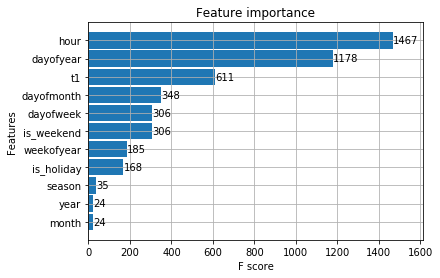

In [0]:
# Plot the most important features
_ = plot_importance(reg, height=0.9)


## Prediction and Results

In [0]:
multi_data_test['Prediction'] = reg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


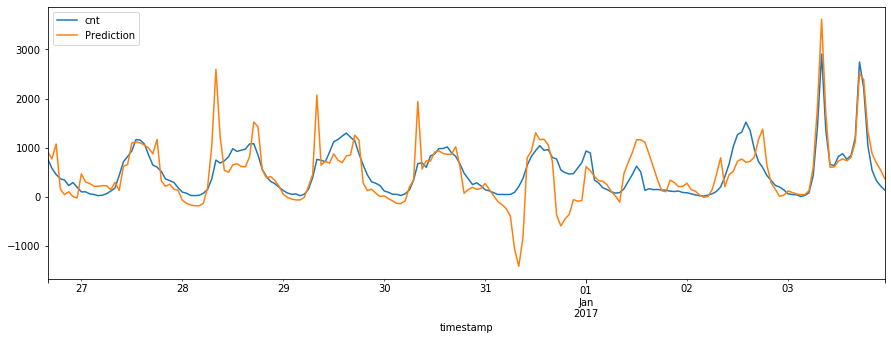

In [0]:
multi_data_test[-200:][['cnt','Prediction']].plot(figsize=(15, 5))


In [0]:
mean_squared_error(y_true=multi_data_test['cnt'],
                   y_pred=multi_data_test['Prediction'])



129110.92408407154

In [0]:
mean_absolute_error(y_true=multi_data_test['cnt'],
                   y_pred=multi_data_test['Prediction'])

236.6201260750344



---



# Exercises
1. Create a new colab Notebook
2. Create energy consumption predictor
3. Create new features based on the timestamp
4. Use different configuration of n_estimators
5. Plot the importance of the features and results

## Practical tips

Download the data using: 

```
!gdown --id 1xaxrs8D1NmVnKPnO6CFjFXjJhnzXY1ML --output PJME_hourly.csv
```

Use 'timestamp' field to parse date and use it as index

